# Programming Test: Learning Activations in Neural Networks
## Dataset: Bank Note
## Source: Kaggle

## Loading the necessary modules and packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from random import random
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

## Downloading the Bank Note data hosted on Kaggle

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
!kaggle datasets download -d ritesaluja/bank-note-authentication-uci-data

bank-note-authentication-uci-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
file_name = "/content/bank-note-authentication-uci-data.zip"
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
BankNote_Authentication.csv                    2019-10-13 19:14:32        46442
Extracting all the files now...
Done!


## Loading the data

In [5]:
data =pd.read_csv("/content/BankNote_Authentication.csv")
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Understanding the data

In [6]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


<Axes: >

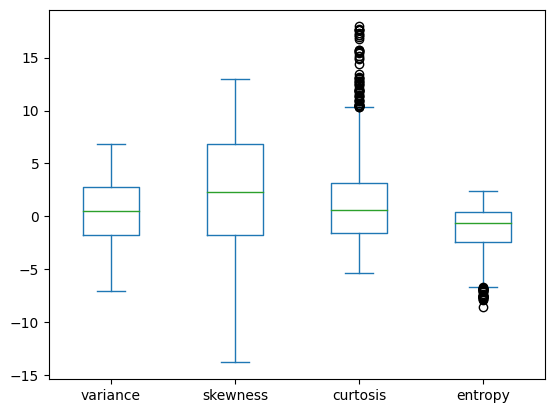

In [8]:
data[["variance","skewness","curtosis","entropy"]].plot(kind="box")

## Splitting the data into train and test and converting them to a numpy array

In [9]:
training_data = data.sample(frac=0.8, random_state=25)
testing_data = data.drop(training_data.index)

In [10]:
training_data = np.array(training_data, "int32")
testing_data  =np.array(testing_data, "int32")

## Training the Model

In [11]:
"""
The function 'model' defines the numbers of neurons in each layer of the neural network consisting of a 
 input layer, one hidden layer and an output layer. It takes in three parameters: number of input neurons,
 number of hidden neurons and number of output neurons. The weights  of neurons in the hidden layer is 
 equal to the number of input neurons and an addition of 1 for the bias. The weights of output neurons is equal to the 
 number of hidden neurons and addition of 1 for the output bias. The number of input neurons will be equal to the 
 number of features in our dataset.
"""
def model(n_input_neurons, n_hidden_neurons, n_output_neurons):
  network =[]
  hidden_layer = [{"weights": [random() for i in range(n_input_neurons+1)]} for i in range(n_hidden_neurons)]
  network.append(hidden_layer)
  output_layer = [{"weights": [random() for i in range(n_hidden_neurons + 1)]} for i in range(n_output_neurons)]
  network.append(output_layer)
  return network

"""
Activating the Neuron
In the below function we are calculating the net input that is Zi = xiwi + b :
where; xi: input, wi: weights and b: bias.
"""
def activate(weights, inputs):
  activation =weights[-1] #bias weight
  for i in range(len(weights)-1):
    activation = activation + weights[i]*inputs[i]
  return activation

"""
Applying an activation function to the net output calculated in the above function.
We're using the softmax activation function.
"""
def activation_function(activation):
  e = np.exp(activation-activation.max())
  return e / np.sum(e,axis=0)

"""
Forward Propogation;
Calculating the output of each layer and propagating forward.
 The output of a layer will be the input to the next layer.
"""
def forward_propagation(network, row):
  inputs =row
  for layer in network:
    new_inputs = []
    for neuron in layer:
      activation=activate(neuron["weights"],inputs)
      neuron["output"]= activation_function(activation) #output of the neuron after activation
      new_inputs.append(neuron["output"]) 
    inputs = new_inputs #outputs will be the input to the next layer.
  return inputs

"""
Calculating the derivative of the softmax activation function
"""
def derivative(output):
  val = output.reshape((-1,1))
  return np.diagflat(output) - np.dot(val, np.transpose(val))

"""
Back Propogation:
Once the forward propogation is completed. We calculate the difference between the actual and the predicted values.
In order to reduce the loss, we back propagate from the output layer to the input layer, updating the
weights and biases. The error propogates backwards along with the weights from the output layer to the hidden layer
neurons.
"""
def back_propagation(network, actual):
  for i in reversed(range(len(network))):
    layer = network[i]
    errors = []
    if i != len(network)-1:
      for j in range(len(layer)):
        error = 0.0
        for neuron in network[i+1]:
          error =error+ (neuron["weights"][j] + neuron["delta"]) #Delta: Error calculated for each neuron
        errors.append(error)
    else:
      for j in range(len(layer)):
        neuron = layer[j]
        errors.append(neuron["output"] - actual[j])
    for j in range(len(layer)):
      neuron = layer[j]
      neuron['delta'] = errors[j] * derivative(neuron['output'])

"""
The weights are updates using the formula:  Wi(new) =Wi(old)  - alpha*Loss
"""
def weight_updation(network, row, learning_rate):
  for i in range(len(network)):
    inputs  = row[:-1]
    if i!=0:
      inputs = [neuron["output"] for neuron in network[i-1]]
    for neuron in network[i]:
      for j in range(len(inputs)):
        neuron["weights"][j] -= learning_rate*neuron["delta"]*inputs[j]
      neuron["weights"][-1] -= learning_rate * neuron["delta"]


"""
Training the given dataset for a fixed number of epochs based on a learning rate
and using the defined architecture.
"""

def training(network, train, learning_rate, n_epochs, n_outputs):
  for epoch in range(n_epochs):
    sum_error = 0
    for row in train:
      outputs = forward_propagation(network, row)
      expected = [0 for i in range(n_outputs)]
      expected[row[-1]]=1
      sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
      back_propagation(network, expected)
      weight_updation(network, row,learning_rate)
    print("-->Epoch:", epoch, "-->Alpha:", learning_rate, "-->Error Sum:", sum_error)
    
     


In [12]:
n_input_neurons = 4 #Dataset has four features
n_output_neurons = 2 #Binary output value
network =model(n_input_neurons, 3, n_output_neurons) #3: Number of hidden layer neurons
train = training(network,training_data, 0.05, 10, n_output_neurons )
for layer in network:
  print("\n",layer)

-->Epoch: 0 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 1 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 2 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 3 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 4 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 5 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 6 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 7 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 8 -->Alpha: 0.05 -->Error Sum: [[1098.]]
-->Epoch: 9 -->Alpha: 0.05 -->Error Sum: [[1098.]]

 [{'weights': [array([[0.89325224]]), array([[0.00711141]]), array([[0.57705045]]), array([[0.67724837]]), array([[0.72156333]])], 'output': array([[1.]]), 'delta': array([[0.]])}, {'weights': [array([[0.12168445]]), array([[0.35442703]]), array([[0.96085067]]), array([[0.35528546]]), array([[0.67407736]])], 'output': array([[1.]]), 'delta': array([[0.]])}, {'weights': [array([[0.88702744]]), array([[0.53873579]]), array([[0.06564393]]), array([[0.46829042]]), array([[0.84875228]])], 

## Testing the model

Testing the model on the trained model with the test dataset. The weights are taken from the trained model.

In [13]:
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

# Transfer neuron activation
def activation_function(activation):
  e = np.exp(activation-activation.max())
  return e / np.sum(e,axis=0)

# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] =activation_function(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

dataset = testing_data
# Test making predictions with the network
network = [[ {'weights': [0.64540026, 0.71768588, 0.876073,0.42101001]}, {'weights': [0.40312267,0.74726241,0.23659416, 0.51287239   ]}],
	[{'weights': [0.87158497,0.65645274, 0.65498254 ]}, {'weights': [0.56295313, 0.52467943,0.72672429    ]}]]

for row in dataset:
 prediction = predict(network, row)

 print("Actual:" , row[-1], "Predicted: ",prediction)
 

Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predicted:  0
Actual: 0 Predic